In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
import math
from pylanetary.navigation import *
from pylanetary.utils import *

'''from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy'''
from scipy import interpolate
from datetime import datetime
from datetime import timedelta
from astroquery.jplhorizons import Horizons
import astropy.units as u


import math
from scipy import ndimage

'''from pylanetary.navigation import *
from pylanetary.utils import Body
#from pylanetary.utils import I_over_F
from pylanetary.utils import *

import astropy.units as u

import math
from scipy import ndimage'''

'from pylanetary.navigation import *\nfrom pylanetary.utils import Body\n#from pylanetary.utils import I_over_F\nfrom pylanetary.utils import *\n\nimport astropy.units as u\n\n\nimport math\nfrom scipy import ndimage'

In [16]:
# functions used within map_maker().

def interceptellip(a,b,alpha,beta,gamma,x0,y0,z0):
    '''
    ; **********************************************************
    ; procedure to find the intercepts (if any) between the line
    ;
    ;  (x-x0)       (y-y0)      (z-z0)
    ;  ------  =    ------   =  ------
    ;  alpha         beta       gamma
    ; 
    ; and the ellipsoid
    ;
    ;
    ;  x^2    y^2    z^2   
    ;  --- +  --- +  ---  = 1
    ;  a^2    a^2    b^2
    ;
    ; Input variables
    ;       a       real    ellipsoid semi-major axis
    ;       b       real    ellipsoid semi-minor axis
    ;       alpha   real    line x-gradient
    ;       beta    real    line y-gradient
    ;       gamma   real    line z-gradient
    ;       x0      real    line x-intercept
    ;       y0      real    line y-intercept
    ;       z0      real    line z-intercept
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if line intercepts, set to -1  otherwise
    ;       x(2)    real    x-intercepts
    ;       y(2)    real    y-intercepts
    ;       z(2)    real    z-intercepts
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3-8-19
    ; **********************************************************
    '''
    a1 = 1.0/a**2 + (beta/(a*alpha))**2 + (gamma/(b*alpha))**2

    b1 = (-2*x0*beta**2/alpha**2 + 2*beta*y0/alpha)/a**2
    b1 = b1 + (-2*x0*gamma**2/alpha**2 + 2*gamma*z0/alpha)/b**2
    
    c1 = ((beta*x0/alpha)**2 - 2*beta*y0*x0/alpha + y0**2)/a**2
    c1 = c1 + ((gamma*x0/alpha)**2 - 2*gamma*x0*z0/alpha + z0**2)/b**2 -1
        
    #;print,a1,1.0/a**2 + (gamma/(b*alpha))**2
    #;print,b1,2*gamma*z0/(alpha*b**2)
    #;print,c1,(y0/a)**2 + (z0/b)**2 -1
    
    xtest = b1**2 - 4*a1*c1

    x = np.zeros(2)
    y = np.zeros(2)
    z = np.zeros(2)
        
    if xtest > 0.0:
        iflag = 1
        x[0] = (-b1 + np.sqrt(xtest))/(2*a1)
        x[1] = (-b1 - np.sqrt(xtest))/(2*a1)
        y[0] = y0 + (beta/alpha)*(x[0]-x0)
        y[1] = y0 + (beta/alpha)*(x[1]-x0)
        z[0] = z0 + (gamma/alpha)*(x[0]-x0)
        z[1] = z0 + (gamma/alpha)*(x[1]-x0)

        # testing to see if solution is on ellipsoid
        test=np.ndarray(len(x))
        for i in range(0,len(x)):
            test[i] = (x[i]/a)**2 + (y[i]/a)**2 + (z[i]/b)**2
        xtest1 = abs(test[0]-1.0)
        xtest2 = abs(test[1]-1.0)
        
        err = 1e-5
        
        if xtest1 > err or xtest2 > err:
            print('Problem in interceptellip - solution not on ellipsoid')
            print('Test =',test)
    else:
        iflag = -1


    return iflag,x,y,z

interceptellip_vec = np.vectorize(interceptellip)

def projposolar(Re,obl,epsilon,latsol,lonsol,se_lon,eoff,poff):
    '''
    ; ************************************************************
    ; Procedure to find latitude and longitude and zenith angle of
    ; intercept between line and ellipsoid
    ;
    ; Input variables
    ;       Re      real    Equatorial Radius (arcsec)
    ;       obl     real    Planetary oblateness
    ;       epsilon real    Sub-observer (planetocentric) latitude
    ;       latsol  real    Sub-solar planetocentric latitude
    ;       lonsol  real    longitude difference between sub-solar and sub-observer
    ;                       points.
    ;       se_lon  real    Sub-observer longitude # added by Emma
    ;       eoff    real    equatorial offset of beam (arcsec)
    ;       poff    real    polar offset of beam (arcsec)
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if real intercept, -1 otherwise
    ;       xlat    real    Planetocentric latitude
    ;       longitude real  xlon+se_lon, offset of longitude added to sub-observer longitude # added by Emma
    ;       xlon    real    Longitude
    ;       zen     real    Zenith angle
    ;       szen    real    Solar zenith angle
    ;       aphi    real    local azimuth angle between sun and observer
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3/8/19
    ; ************************************************************
    '''
    
    dtr = np.pi/180.0 # radians/degrees
    Rp = Re*(1.0-obl)
    
    x0 = 0.0
    y0 = eoff
    z0 = poff/np.cos(epsilon*dtr)
    
    alpha = np.sin(np.pi/2.0 - epsilon*dtr)
    beta = 0.0
    gamma = np.cos(np.pi/2.0 - epsilon*dtr)
    
    # commenting out to give program my own iflag map
    iflag,x,y,z = interceptellip_vec(Re,Rp,alpha,beta,gamma,x0,y0,z0)
    #print(iflag)
    
    xlat = 0.0
    xlon = 0.0
    zen = 0.0
    
    # !!! getting rid of iflag statement here because I already have the maps set up for real intercepts below
    #if iflag > 0:
    # if real intercept, find lat, long, and zenith

    # find distance along line of sight
    lambdaa = (x-x0)/alpha
    if lambdaa[0] > lambdaa[1]:
        inear = 0
    else:
        inear = 1

    x1 = x[inear]
    y1 = y[inear]
    z1 = z[inear]

    r = np.sqrt(x1**2 + y1**2 + z1**2)

    theta = np.arccos(z1/r)
    xlat = 90.0 - theta/dtr

    #; convert to planetographic latitude
    #; xlat = np.arctan(((Re/Rp)**2)*np.tan(xlat*dtr))/dtr

    cphi = x1/(r*np.sin(theta))

    if cphi > 1.0:
        cphi = 1.0
    if cphi < -1.0:
        cphi = -1.0

    phi = np.arccos(cphi)
    if y1 < 0.0:
        phi = -phi
    xlon = phi/dtr        

    # Finding aphi, zen, szen - don't mess with these, want to still output them

    v1 = np.zeros(3)
    v2 = np.zeros(3)
    v3 = np.zeros(3)

    # v1 is normal vector of point observed
    v1[0] = x1/r
    v1[1] = y1/r
    v1[2] = z1/r

    v2[0] = alpha
    v2[1] = beta
    v2[2] = gamma

    summ = 0.0

    for i in range(0,3):
        summ += v1[i]*v2[i]
    zen = np.arccos(summ)/dtr

    # Finding aphi

    alphasol = np.sin(np.pi/2.0 - latsol*dtr)*np.cos(lonsol*dtr)
    betasol =  np.sin(np.pi/2.0 - latsol*dtr)*np.sin(lonsol*dtr)
    gammasol = np.cos(np.pi/2 - latsol*dtr)
    v3[0]=alphasol
    v3[1]=betasol
    v3[2]=gammasol

    summ = 0.0
    for i in range(0,3):
        summ += v1[i]*v3[i]
    szen = np.arccos(summ)/dtr

    cphase = 0.0

    for i in range(0,3):
        cphase += v2[i]*v3[i]

    a = np.cos(zen*dtr)*np.cos(szen*dtr)
    b = np.sin(zen*dtr)*np.sin(szen*dtr)

    if b == 0.0:
        aphi = 180.0
    else:
        cphi = (cphase-a)/b
        aphi = 180.0-np.arccos(cphi)/dtr
            
    longitude = se_lon-xlon # offset of longitude added to sub-observer longitude
    # Remember that system III longitude increases to the west
    
    #return xlat,longitude
    return iflag,xlat,longitude,xlon,zen,szen,aphi
    #return xlat,longitude,xlon,zen,szen,aphi


projposolar_vec = np.vectorize(projposolar)

In [57]:
def map_maker(filename, plot_maps=0,  ut_date='DATE_OBS', ut_time='TIME_OBS', target='OBJECT', location_code='568', pixelscale=0.115696):
    
    print('Loading image info and querying Horizons...')
    
    #tuples of planets and their Horizons codes. Only gas giants for now, can add terrestrial planets. Horizons code, name, equatorial radius (km), polar radius (km), oblateness. would be nice to be able to pull radii from horizons eventually
    planets = ('599','Jupiter',71492,66854,0.06487),('699','Saturn',60268,54364,0.09796),('799','Uranus',25559,24973,0.0229),('899','Neptune',24766,24342,0.0171)
    
    # first, use ModelEllipsoid to generate maps for a given image. Need to get sub-obs lon and lat, pixel scale, north polar angle, equatorial radius and polar radius from Horizons by pulling info from header.

    # import image
    im = fits.open(filename)
    header = im[0].header
    data = im[0].data
    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('original data')
        plt.show()


    # based on UT time/date and location of observations, query Horizons for viewing geom info
    UT_date = header[ut_date] 
    UT_time = header[ut_time]
    target = 'Jupiter' # header[target] # observed planet. maybe just put this as planet as optional input

    # Account for fractional seconds in UT_time if it exists. datetime does not like fractional seconds.
    if '.' in UT_time:
        nofrag, frag = UT_time.split('.')
        UT_time = nofrag    

    # Query horizons. !! The date/time format for UT_date and UT_time as used in date_obj are specific to the format used by the IRTF.

    for k in planets: # find planet code, r_eq, r_pol, obl
        if k[1] == target: # assumes target string is exactly correct. might be an issue if there are additional spaces
            id_number = k[0]; planet_label = k[1]; req = k[2]; rpol = k[3]; obl = k[4]

    # calculate julian date
    date_obj = datetime.strptime(UT_date+' '+UT_time, '%Y-%m-%d %H:%M:%S') # define datetime object based on UT date and time. Might have issue bc seconds are fractional
    date_only_obj = datetime.strptime(UT_date, '%Y-%m-%d')
    h = int(date_obj.strftime("%H"))
    m = int(date_obj.strftime("%M"))
    s = int(date_obj.strftime("%S"))
    dt = timedelta(hours=h, minutes=m, seconds=s)
    secs_per_day = 24*60*60    # hours * mins * secs
    jd_time_fraction = dt.total_seconds()/secs_per_day # fraction of day time, to add to date

    jd = date_only_obj.toordinal() + 1721424.5 + jd_time_fraction # based on https://stackoverflow.com/questions/13943062/extract-day-of-year-and-julian-day-from-a-string-date

    # define horizons query
    obj = Horizons(id=id_number, location=location_code, epochs=jd) 

    # put ephimerides into a table
    table = obj.ephemerides()
    distance = table['delta'][0]*1.496E8 # in AU, convert to km

    # define values needed for ModelEllopsoid
    ob_lon = table['PDObsLon'][0] #sub-observer longitude, degrees
    ob_lat = table['PDObsLat'][0] #sub-observer latitude, degrees, planetocentric
    sol_lon = table['PDSunLon'][0] #sub-solar longitude, degrees
    sol_lat = table['PDSunLat'][0] #sub-solar latitude, degrees, planetocentric
    pixscale_km = np.arctan(pixelscale*(1/206265))*distance
    np_ang = table['NPole_ang'][0] #degrees 

    # save values of values needed for projposolar, outside of eoff and poff. gratiutous but I'm tired
    Re = (req/pixscale_km)*pixelscale # equatorial radius in arcsec
    epsilon = ob_lat # Sub-observer (planetographic) latitude
    latsol = sol_lat # Sub-solar planetocentric latitude
    lonsol = sol_lon-ob_lon # longitude difference between sub-solar and sub-observer points

    # define offset and rotation values to be used for both data and iflag map rotation
    # !! hard coded planet center value keywords for IRTF
    cx = im[0].header['cx']; cy = im[0].header['cy']
    # x and y center of image
    x1 = im[0].header['naxis1']/2; y1 = im[0].header['naxis2']/2
    x_offset = int(cx-x1); y_offset = int(cy-y1)
    rot_ang = np.copy(np_ang)


    # - - - - - - - - - - - - - - - - - - - - - - 
    # generate iflag map using nav, rotate and crop

    # use pylanetary just to generate map of where planet is and isn't, Might not need all lines here but keeping anyways to make sure nothing breaks
    obs_time = UT_date + ' ' + UT_time
    ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol)
    body = Body(target, epoch=obs_time, location=location_code) 
    model = ModelBody(body, pixelscale, shape=(len(data),len(data[0])))
    nav = Nav(data, body, pixelscale)

    #diagnostic
    #plt.imshow(nav.lat_g)
    #plt.title('latitude, unrotated and uncentered and uncropped')
    #plt.show()

    # use nav to make iflag map
    rotated_lat_map = np.copy(nav.mu)
    rotated_lat_map[np.where(np.isnan(rotated_lat_map)==True)] = 0
    # don't need to center since nav does that already
    #rotated_lat_map=np.roll(rotated_lat_map,-y_offset,axis=0)
    #rotated_lat_map=np.roll(rotated_lat_map,-x_offset,axis=1)
    #diagnostic plot
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered')
    #plt.show()

    # rotate
    rotated_lat_map = ndimage.rotate(rotated_lat_map,rot_ang)
    #diagnostic
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered and rotated')
    #plt.show()

    # crop; ! might want to just use the same crop values for both data and iflag centeirng?
    if len(rotated_lat_map) > header['naxis1'] or len(rotated_lat_map[0]) > header['naxis2']:
        x_crop = int((len(rotated_lat_map)-header['naxis1'])/2)
        y_crop = int((len(rotated_lat_map[0])-header['naxis2'])/2)
        rotated_lat_map = rotated_lat_map[x_crop:-x_crop,y_crop:-y_crop]

    #diagnostic
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered cropped and rotated')
    #plt.show()

    # - - - - - - - - - - - - - - - - - - - - - - 
    # rotate and crop data after it's been used to orient the iflag map
    # rotate and center image 
    data=np.roll(data,-y_offset,axis=0)
    data=np.roll(data,-x_offset,axis=1)

    data = ndimage.rotate(data,np_ang)

    # crop centered and rotated data
    if len(data) > header['naxis1'] or len(data[0]) > header['naxis2']:
        x_crop = int((len(data)-header['naxis1'])/2)
        y_crop = int((len(data[0])-header['naxis2'])/2)
        data = data[x_crop:-x_crop,y_crop:-y_crop]
    np_ang_orig = np.copy(np_ang)
    np_ang = 0
    x_offset = 0; y_offset = 0

    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('centered rotated and cropped data')
        plt.show()


    # make sure iflag map and data have the same dimensions (otherwise will have issues mapping arrays later)
    if len(data) != len(rotated_lat_map) or len(data[0]) != len(rotated_lat_map[0]):
        print('! size of iflag map and data are not equal !')

    # use the rotated latitude map to generate the correct eoff and poff arrays
    # since using nd image rotate on 0's, very close to 0, rounding down. !!! very janky. 
    iflag_map = np.copy(rotated_lat_map)
    iflag_map = np.round(iflag_map,1)
    iflag_map[np.where(iflag_map==0)] = 0
    iflag_map[np.where(iflag_map!=0)] = 1


    # - - - - - - - - - - - - - - - - - - - - -
    # find eoff and poff, equatorial and polar offset needed for projposolar.

    # finding center point based on data array (should be same as x1 and y1 earlier?)
    x_center = len(data)/2
    y_center = len(data[0])/2

    # don't need but might be helpful for testing
    unrot_x = np.where(iflag_map==1)[0]
    unrot_y = np.where(iflag_map==1)[1]

    # list of coordinates where the planet is. Shifted to have origin at middle of image/planet
    x = unrot_x-x_center
    y = unrot_y-y_center

    np_ang_radians = np_ang*0.0174533 # rad/deg # in case still need to rotate. should be 0 if data already rotated

    # flipped these bc lat and long maps where backwards
    eoff = -x*np.sin(np_ang_radians)+y*np.cos(np_ang_radians)
    poff = x*np.cos(np_ang_radians)+y*np.sin(np_ang_radians)


    # eoff and poff correspond to locations in np.where(np.isnan(nav.mu)==False), so zen etc. should be assigned to those locations. If a pixel location listed in np.where(np.isnan(nav.mu)==False) is not assigned a zen value, interpolate between adjacent zen values.

    # translate the pixel offsets to arcsec offsets
    eoff*=pixelscale 
    poff*=pixelscale

    # map eoff and poff values onto planet pixel locations using iflag
    eoff_final = np.copy(iflag_map)
    poff_final = np.copy(iflag_map)

    eoff_final[np.where(iflag_map==1)] = eoff
    poff_final[np.where(iflag_map==1)] = poff

    eoff_final[np.where(iflag_map!=1)] = np.nan
    poff_final[np.where(iflag_map!=1)] = np.nan

    if plot_maps == 1:
        plt.imshow(eoff_final,origin='lower')
        plt.title('equatorial offset in arcsec')
        plt.colorbar()
        plt.show()
        plt.imshow(poff_final,origin='lower')
        plt.colorbar()
        plt.title('polar offset in arcsec')
        plt.show()

    # run projposolar, usng iflag map to find location of planet pixels
    print('Generating maps...(ignore plethora of errors, everything will be fine)')

    # will get mad if passed nans
    # generate maps of all the following values:
    iflag,latitude_final,longitude_final,xlon,zen,szen,aphi = projposolar_vec(Re,obl,epsilon,latsol,lonsol,ob_lon,eoff_final,poff_final)

    # flip maps along vertical axis (probably more elegant way to do this)
    szen=np.flip(szen,axis=1)
    aphi=np.flip(aphi,axis=1)
    
    if plot_maps == 1:
        plt.imshow(latitude_final,origin='lower')
        plt.colorbar(label='Latitude')
        plt.show()
        
        plt.imshow(longitude_final,origin='lower')
        plt.colorbar(label='Longitude (Sys III)')
        plt.show()
        
        plt.imshow(zen,origin='lower')
        plt.colorbar(label='Zenith emission angle')
        plt.show()
        
        plt.imshow(szen,origin='lower')
        plt.colorbar(label='Solar zenith angle')
        plt.show()
        
        plt.imshow(aphi,origin='lower')
        plt.colorbar(label='Azimuth angle')
        plt.show()

    return iflag,latitude_final,longitude_final,xlon,zen,szen,aphi

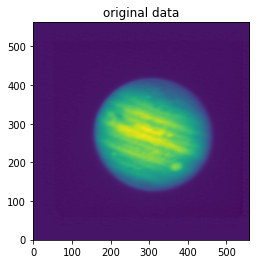

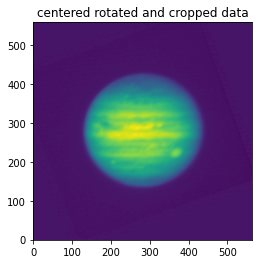

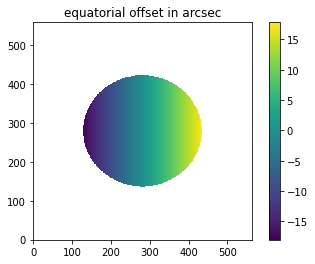

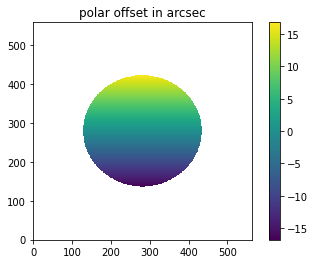

generating maps...


/Users/emmadahl/opt/anaconda3/envs/pylanetary-tester/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in interceptellip (vectorized)
  outputs = ufunc(*inputs)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_6197/1088850928.py:151: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(z1/r)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_6197/1088850928.py:176: RuntimeWarning: invalid value encountered in scalar divide
  v1[0] = x1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_6197/1088850928.py:177: RuntimeWarning: invalid value encountered in scalar divide
  v1[1] = y1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_6197/1088850928.py:178: RuntimeWarning: invalid value encountered in scalar divide
  v1[2] = z1/r


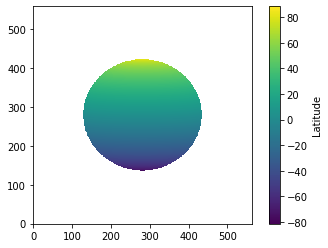

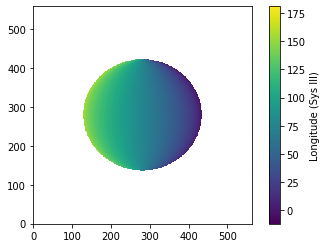

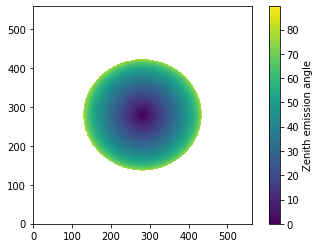

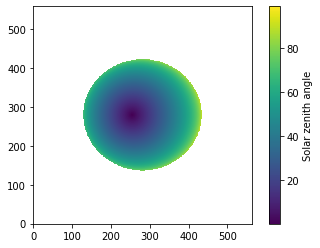

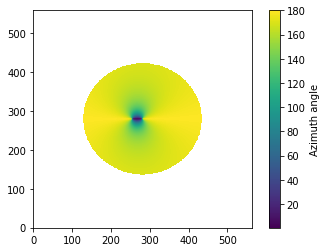

In [56]:
# test it here
iflag,latitude_final,longitude_final,xlon,zen,szen,aphi = map_maker('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits',plot_maps=1)

In [ ]:

# the below functions are still a work in progress; I've got other notebooks that have stuff I'm going to add later:


In [ ]:
def spex_wavelengths(filename):
    '''
    Routine to find the correct wavelength for a SpeX Guidedog image given certain OS filter and G filter combos.
    wavelength: midpoint originally from table at http://irtfweb.ifa.hawaii.edu/~spex/work/filters/filters.html (but link seems to be broken now)
    
    input
    -filename: string, path+name of fits file to read. presumption is that this is a guidedog image.
    
    output
    -Wavelength float. mircons
    will return error if no matching wavelength is found
    '''
    
    wavelength = -1
    
    im = fits.open(filename)
    header = im[0].header
    osfilt = header['OSF']
    gfilt = header['GFLT']
    
    if gfilt == 'Open':
        # define list of tuples
        wavelength_tuple = (('Open',0.00),('Blank',0.00),('PK-50',2.5), ('Opt',2.5),  ('0.1',0.1), ('Long4',5.2), ('Long5',3.86), ('Long6',3.33), ('Short3',2.22), ('Short4',1.63), ('Short5',1.27), ('Short6',1.15), ('Short7',.95), ('CH4_l' ,1.69), ('CH4_s',1.58))
        for j in wavelength_tuple:
            if j[0] == osfilt:
                wavelength = j[1]
                return wavelength
        
    elif gfilt == 'H' and ofilt == 'CH4_s':
        wavelength = 1.58
        return wavelength
    elif gfilt == 'H' and ofilt == 'CH4_l':
        wavelength = 1.69
        return wavelength
        
    else:
        # define list of tuples
        wavelength_tuple = (('Open',0.00), ('Blank',0.00), ('Z',1.00),('J',1.215), ('H',1.654), ('K',2.23), ("L'",3.80), ('Lp',3.80), ("M'",4.76) ,('FeII',1.64), ('H2',2.12), ('Bry',2.16), ('contK',2.26), ('CO',2.29), ("M'+ND1",4.76), ('3.417',3.417), ('3.454',3.454), ('5.1',5.100))
        for j in wavelength_tuple:
            if j[0] == gfilt:
                wavelength = j[1]
                return wavelength
        
    if wavelength == -1:
        print('Error! No matching wavelength found for filter combo by spex_wavelengths()')
        return

In [ ]:
def spextraction_images(inputfile, data_list, wavelength_keyword='OSF'):    
    '''    
    Extract spectra based on user input, using maps generated by map_maker(). This version is for extracting spectra from images. Maybe make other versions later?
    
    inputfile - string, path+name of input file. contains code for what kind of spectra to make (1=equal mu bins within a given latitude/longitude bin). For now, only 1 format but will change that.
        data_list - input file containing paths+names of images to extract spectra from. Proabbly just want one image per wavelength and grouped together in time

    '''
    
    datalist = np.loadtxt(input_list) # load list of images
    guidedog_wavelengths = () # list of tuples that correspond to the filters used and corresponding wavelengths. OSF, GFLT, and then WL
    
    # sort images by wavelength
    wl = []
    image = []
    for j in datalist:
        im = fits.open(j)
        if wavelength_keyword == 'OSF': # if the image is from guidedog
            for q in range(0,len(guidedog_wavelengths)):
                if q[0] == im[0].header['OSF'] and q[1] == im[0].header['GFILT']:
                    wl.append(q[2])
            
        
        
    
    # open input file and determine type of spectrum to make
    with open(inputfile,'r') as f:
        f.readlines()
        spec_type = value # find and define
        if value == 1:
            # if mu-binned lat spectrum, find other requirements:
            
        elif value == 2:
            # if different kind of spectrum, do something else.
            

            
    
    # loop through images in list, in order of wavelength
    for i in datalist:
        filename = datalist[i]
        # make maps for each image/wavelength. Is there a way to write this avoid making new maps every time? save them somewhere with the obs_time in the file name, and we can check to see if it's been saved somewhere already.
        iflag,latitude_final,longitude_final,xlon,zen,szen,aphi = map_maker(filename)
            
    # based on inputs above, extract spectra:
    
    # copied one section over from NIRI_aligner:
    
    # number of NAIC wavelengths
    n_wavel = 5

    # define bins w/ the size of bin in mu-space
    #d_mu = 0.05 # original value
    #d_mu = 0.115
    d_mu = 0.1
    mu_min = np.copy(mu_min_value)
    mu_max = 1.0
    w_mu = 0.1
    n_mu = int((mu_max-mu_min)/d_mu)
    n_bins = n_mu*2+1

    # define bins based on n_mu (number of bins)
    '''
    mu_min = np.copy(mu_min_value)
    mu_max = 1.0
    n_mu = 11
    d_mu = ((mu_max-mu_min)/n_mu)
    w_mu = 2*d_mu
    '''

    # will look for pixels between these lat and longs
    lat_min = -3.0
    lat_max = 2.0

    # make empty arrays for binning section
    extracted_spectrum_sum = np.zeros((n_bins,n_wavel))
    extracted_sum = np.zeros((n_bins,n_wavel))
    extracted_lat_sum = np.zeros((n_bins,n_wavel))
    extracted_long_sum = np.zeros((n_bins,n_wavel))
    extracted_emiss_sum = np.zeros((n_bins,n_wavel))
    extracted_solar_sum = np.zeros((n_bins,n_wavel))
    extracted_azi_sum = np.zeros((n_bins,n_wavel))

    for f in range(0,len(wavel_spxs)):

        # load lists of geometric info for each wavelength/frame
        spxs = np.loadtxt(geo_list_directory+str(f)+'_spx')
        mu_spxs = np.loadtxt(geo_list_directory+str(f)+'_mu_spx')
        lat_spxs = np.loadtxt(geo_list_directory+str(f)+'_lat_spx')
        long_spxs = np.loadtxt(geo_list_directory+str(f)+'_long_spx')
        solar_spxs = np.loadtxt(geo_list_directory+str(f)+'_solar_spx')
        azimuth_spxs = np.loadtxt(geo_list_directory+str(f)+'_azi_spx')
        lcm_spxs = np.loadtxt(geo_list_directory+str(f)+'_lcm_spx')

        # once lists are loaded, extract spectra
        i_wavel = np.copy(f)
        wavel = wavel_spxs[f]

        print( 'Extracting spectra for',wavel,'nm...')

        h = 0 # bin index, for assigning values in arrays

        print( 'west')
        for i_mu in range(0,n_mu):
            # print mu index
            #print 'i_mu:',i_mu
            mu_0 = mu_min + float(d_mu*i_mu)
            mu_1 = mu_min + float(d_mu*i_mu) + w_mu
            # print mu limits
            #print 'mu_0, mu_1:',mu_0,mu_1

            n_spx = len(spxs) # number of pixels in location arrays/lists
            for i_spx in range(0,n_spx):
                # pull relavent values from lists
                radiance = spxs[i_spx]
                mu_spx = mu_spxs[i_spx]
                emiss_spx = (180/math.pi)*np.arccos(mu_spx)
                lat_spx = lat_spxs[i_spx]
                long_spx = long_spxs[i_spx]
                solar_spx = solar_spxs[i_spx]
                azimuth_spx = azimuth_spxs[i_spx]
                lcm_spx = lcm_spxs[i_spx]

                #only interested in spectra over EZ
                #if lat_spx < lat_max or lat_spx > lat_min:
                if lat_spx < lat_max and lat_spx > lat_min:
                    #if wavel_spx == wavel and mu_spx > mu_0 and mu_spx < mu_1 and long_spx < lcm_spx:
                    #long_spx < lcm_spx - east
                    #long_spx > lcm_spx - west
                    if mu_spx > mu_0 and mu_spx < mu_1 and long_spx > lcm_spx:
                        extracted_spectrum_sum[h,i_wavel] = extracted_spectrum_sum[h,i_wavel] + radiance
                        extracted_lat_sum[h,i_wavel] = extracted_lat_sum[h,i_wavel] + lat_spx
                        extracted_long_sum[h,i_wavel] = extracted_long_sum[h,i_wavel] + long_spx
                        extracted_emiss_sum[h,i_wavel] = extracted_emiss_sum[h,i_wavel] + emiss_spx
                        extracted_solar_sum[h,i_wavel] = extracted_solar_sum[h,i_wavel] + solar_spx
                        extracted_azi_sum[h,i_wavel] = extracted_azi_sum[h,i_wavel] + azimuth_spx

                        extracted_sum[h,i_wavel] = extracted_sum[h,i_wavel] + 1.
                #print extracted_lat_sum[i_mu,i_wavel]

            h+=1
    
    
    
    
    # include option to plot. some options for this in NIRI_aligner.ipynb
    
    

In [ ]:
# this should be a subroutine for spextraction

def spec_file_maker(inputfile, input_list, format='Nemesis'):
    '''
    spx,lat,long,zen,szen,aphi
    format - string, label for desired format of spectrum file. currently only coded for Nemesis spx files.
    '''
    
    # pull spectra
    spextraction_images(input_list)
    
    
    
    # - - - - - - - - - - -
    # from NIRI_aligner.ipynb. will need to modify
    
    r = 5.073 # AU

    FWHM = 0
    LATITUDE = np.mean(latitude) # the average latitude of all spectra in the file
    LONGITUDE = np.mean(longitude) # the average longitude of all spectra in the file
    NGEOM = np.copy(n_bins)
    NAV = 1

    # print header
    print('     ',FWHM,'  ', np.round(LATITUDE,3),'  ', np.round(LONGITUDE,3),'  ', NGEOM )

    # for spectra headers
    NCONV = 5
    NAV = 1

    for p in range(0,n_bins):
        # define header for that mu bin

        FLAT = np.mean(latitude[p,:])
        FLON = np.mean(longitude[p,:])
        SOL_ANG = np.mean(solar_emiss_ang[p,:])
        EMISS_ANG = np.mean(emission_ang[p,:])
        AZI_ANG = np.mean(azi_ang[p,:])
        WGEOM = '1'

        print( '     ',NCONV)
        print( '     ',NAV)
        print( '     ',np.round(FLAT,3),'  ',np.round(FLON,3),'  ',np.round(SOL_ANG,3),'  ',np.round(EMISS_ANG,3),'  ',np.round(AZI_ANG,3),'  ',WGEOM)

        # print spectrum
        for j in range(0,len(wavel_spxs)):
            # raw spectrum value*OPAL correction*IF factor*radiance conversion
            F_Solar = ufloat(F_S_corrwl[j],F_S_corrwl[j]*0.01)

            spectrum_value_with_error = ufloat(spec[p,:][j],np.sqrt(spec[p,:][j]))*1e-7*(1/0.0001)*((F_Solar*1e-22)/(r**2)/math.pi/1000) #1e-22 from difference between thullier solar spec files

            # print wavelength in microns, radiance, error:
            print( '     ',round(wavel_spxs[j],4), round(spectrum_value_with_error.nominal_value,12), round(spectrum_value_with_error.std_dev,12))

            # plot radiance spectra:
            #plt.plot(wavel_spxs[j],spectrum_value_with_error.nominal_value,'.')
        #plt.show()
